# Análisis del Modelo Insumo-Producto y Ciencia de Datos

Este notebook realiza un análisis sectorial basado en la teoría del Modelo Insumo-Producto (MIP) utilizando datos de la Encuesta Anual de la Industria Manufacturera (EAIM), integrando técnicas de Ciencia de Datos como PCA y Clustering, y relacionando el desempeño sectorial con variables macroeconómicas (IGAE y Desempleo).

## 1. Carga y Preprocesamiento de Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Configuración de visualización
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)

# Rutas de archivos
path_eaim = 'c:/Users/gabri/OneDrive/_Proyectos_Python/Modelo IP/Datos/EAIM.xlsx'
path_igae = 'c:/Users/gabri/OneDrive/_Proyectos_Python/Modelo IP/Datos/IGAE.xlsx'
path_desempleo = 'c:/Users/gabri/OneDrive/_Proyectos_Python/Modelo IP/Datos/Tasadedesempleo.xlsx'

# Cargar datos
print("Cargando EAIM...")
df_eaim = pd.read_excel(path_eaim, sheet_name='tr_eaim_cifra_2018_2023')

print("Cargando IGAE...")
df_igae = pd.read_excel(path_igae)

print("Cargando Tasa de Desempleo...")
df_desempleo = pd.read_excel(path_desempleo)

print("Datos cargados exitosamente.")

Cargando EAIM...
Cargando IGAE...
Cargando Tasa de Desempleo...
Datos cargados exitosamente.


## 2. Limpieza y Selección de Variables

Seleccionamos las variables clave para el análisis Insumo-Producto:
- **PBT**: Producción Bruta Total ($X_j$)
- **K000A**: Consumo Intermedio ($CI_j$)
- **VAT**: Valor Agregado Bruto ($V_j$)
- **POTOT**: Personal Ocupado Total ($L_j$)
- **CODIGO_ACTIVIDAD**: Identificador del sector
- **ANIO**: Año de referencia

In [2]:
# Selección de columnas clave
cols_interes = ['CODIGO_ACTIVIDAD', 'ANIO', 'PBT', 'K000A', 'VAT', 'POTOT', 'ESTATUS']
df_ip = df_eaim[cols_interes].copy()

# Convertir columnas numéricas si hay algún error de tipo
cols_num = ['PBT', 'K000A', 'VAT', 'POTOT']
for col in cols_num:
    df_ip[col] = pd.to_numeric(df_ip[col], errors='coerce')

# Eliminar filas con nulos en variables clave
df_ip.dropna(subset=cols_num, inplace=True)

# Filtrar para un año reciente para el análisis estático (ej. 2022)
anio_analisis = 2022
df_2022 = df_ip[df_ip['ANIO'] == anio_analisis].copy()

print(f"Datos filtrados para el año {anio_analisis}: {df_2022.shape}")
df_2022.head()

Datos filtrados para el año 2022: (314, 7)


,CODIGO_ACTIVIDAD,ANIO,PBT,K000A,VAT,POTOT,ESTATUS
1256,31-33,2022,12150276952,7649338196,4500938756,4925214,Cifras definitivas
1257,311,2022,1787319687,1128484420,658835267,884308,Cifras definitivas
1258,3111,2022,187925382,149004764,38920618,20713,Cifras definitivas
1259,311110,2022,187925382,149004764,38920618,20713,Cifras definitivas
1260,3112,2022,328438162,254368257,74069905,36012,Cifras definitivas


## 3. Cálculo de Coeficientes Técnicos (Enfoque Sectorial)

Basado en la identidad fundamental del MIP: $X_j = CI_j + V_j$

Calculamos:
1. **Coeficiente de Insumo ($c_j$)**: Proporción de la producción destinada a cubrir costos de insumos.
   $$ c_j = \frac{CI_j}{X_j} $$
2. **Coeficiente de Valor Agregado ($v_j$)**: Capacidad del sector para generar riqueza nueva.
   $$ v_j = \frac{V_j}{X_j} $$
3. **Productividad Laboral ($p_j$)**: Producción por trabajador.
   $$ p_j = \frac{X_j}{L_j} $$

In [3]:
# Calcular coeficientes
df_2022['Coef_Insumo'] = df_2022['K000A'] / df_2022['PBT']
df_2022['Coef_ValorAgregado'] = df_2022['VAT'] / df_2022['PBT']
df_2022['Productividad_Laboral'] = df_2022['PBT'] / df_2022['POTOT']

# Verificar consistencia (Coef_Insumo + Coef_ValorAgregado debería ser aprox 1)
df_2022['Suma_Coef'] = df_2022['Coef_Insumo'] + df_2022['Coef_ValorAgregado']

print("Estadísticas descriptivas de los coeficientes:")
print(df_2022[['Coef_Insumo', 'Coef_ValorAgregado', 'Productividad_Laboral', 'Suma_Coef']].describe())

Estadísticas descriptivas de los coeficientes:
       Coef_Insumo  Coef_ValorAgregado  Productividad_Laboral  Suma_Coef
count   314.000000          314.000000             314.000000      314.0
mean      0.575925            0.424075            3839.715315        1.0
std       0.124938            0.124938            5867.590182        0.0
min       0.227774            0.128102             110.105831        1.0
25%       0.517128            0.325648            1009.512757        1.0
50%       0.583218            0.416782            2086.651224        1.0
75%       0.674352            0.482872            3939.142567        1.0
max       0.871898            0.772226           48853.609307        1.0


## 4. Análisis de Componentes Principales (PCA)

Utilizamos PCA para reducir la dimensionalidad y visualizar cómo se distribuyen los sectores en función de sus características productivas (Insumos, Valor Agregado, Productividad).

Varianza explicada por componente: [0.72673054 0.27326946]


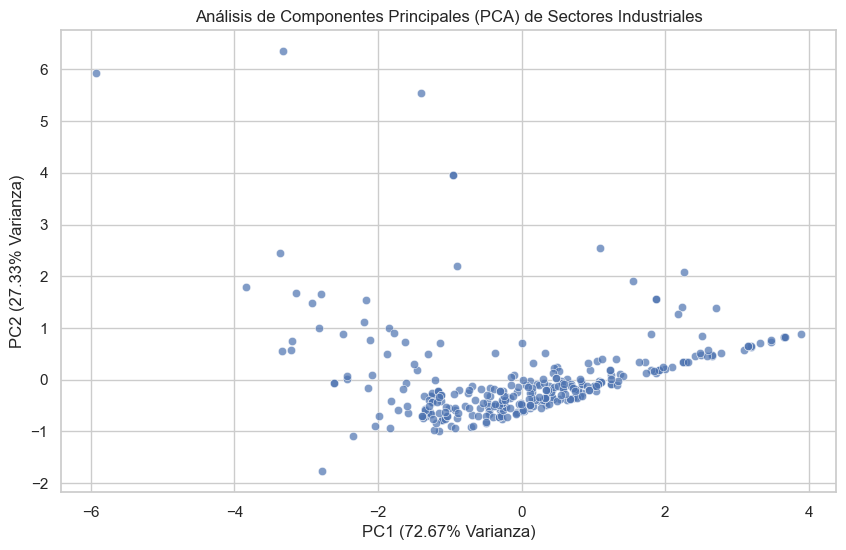

In [4]:
# Selección de features para PCA
features = ['Coef_Insumo', 'Coef_ValorAgregado', 'Productividad_Laboral']
X = df_2022[features]

# Estandarización de datos (importante para PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

print("Varianza explicada por componente:", pca.explained_variance_ratio_)

# Visualización del PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, alpha=0.7)
plt.title('Análisis de Componentes Principales (PCA) de Sectores Industriales')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} Varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} Varianza)')
plt.show()

## 5. Clustering de Sectores (K-Means)

Agrupamos los sectores en clusters para identificar tipologías industriales (ej. "Alta Productividad", "Intensivos en Trabajo", etc.).

c:\Users\gabri\anaconda3\envs\tripleten\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\gabri\anaconda3\envs\tripleten\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\gabri\anaconda3\envs\tripleten\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\gabri\anaconda3\envs\tripleten\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: 

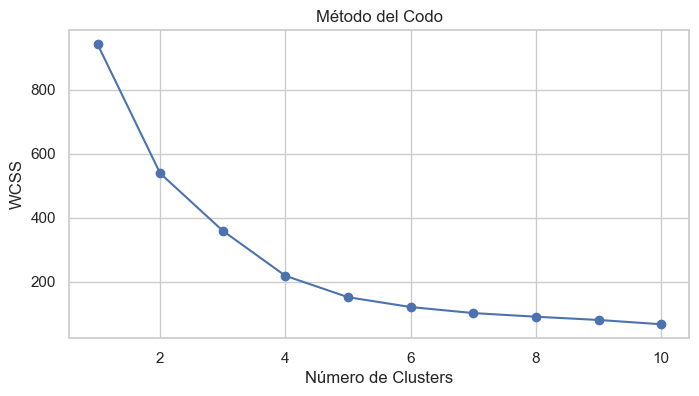

c:\Users\gabri\anaconda3\envs\tripleten\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


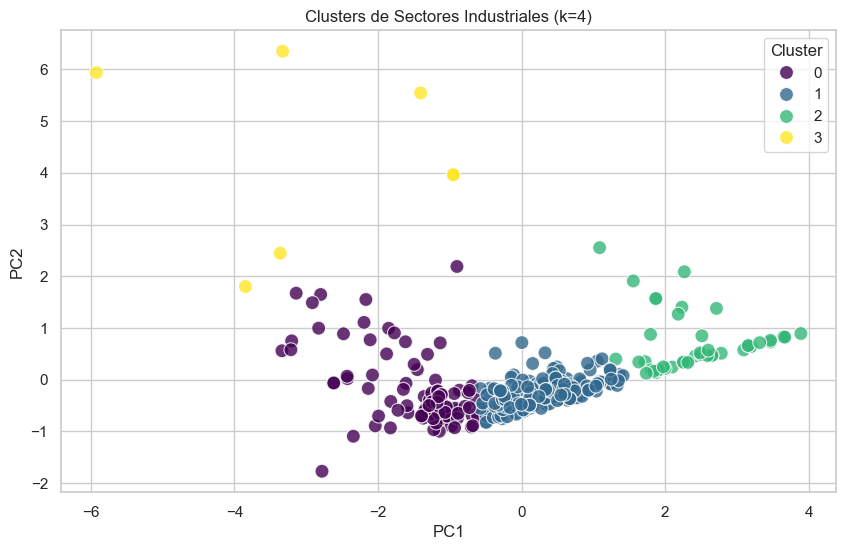

In [5]:
# Determinar el número óptimo de clusters (Método del Codo - simplificado visualmente)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.show()

# Aplicar K-Means con k=4 (hipótesis inicial)
k = 4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Agregar clusters al dataframe original
df_2022['Cluster'] = clusters
pca_df['Cluster'] = clusters

# Visualizar clusters en el espacio PCA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.8)
plt.title(f'Clusters de Sectores Industriales (k={k})')
plt.show()

## 6. Caracterización de los Clusters

Analizamos los promedios de cada variable por cluster para interpretar su significado económico.

         Coef_Insumo  Coef_ValorAgregado  Productividad_Laboral
Cluster                                                        
0           0.705259            0.294741            5859.182747
1           0.559877            0.440123            1827.673790
2           0.352365            0.647635            2455.950576
3           0.670331            0.329669           33240.096036


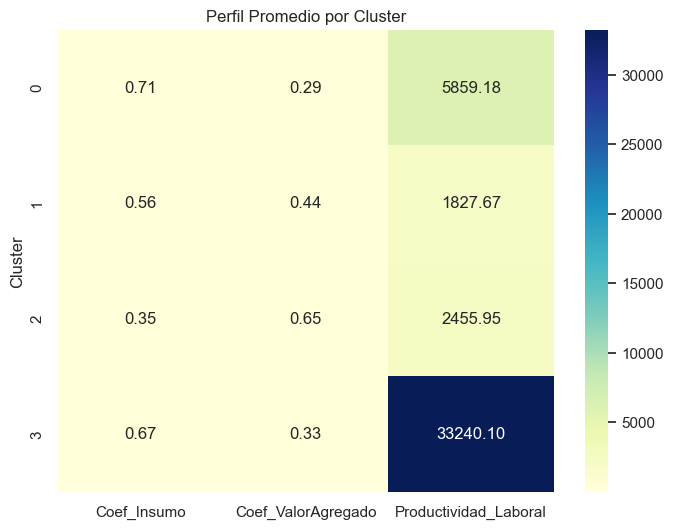

In [6]:
cluster_summary = df_2022.groupby('Cluster')[['Coef_Insumo', 'Coef_ValorAgregado', 'Productividad_Laboral']].mean()
print(cluster_summary)

# Visualización de perfiles
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_summary, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Perfil Promedio por Cluster')
plt.show()

## 7. Integración con Variables Macro (IGAE y Desempleo)

Analizamos la relación entre la producción manufacturera total y las variables macroeconómicas a lo largo del tiempo (2018-2023).

Datos Macro Integrados:
   ANIO  Produccion_Total_Manufactura  IGAE Total_ crecimiento anual  \
0  2018                   37577980016                       2.015000   
1  2019                   37968416192                      -0.204167   
2  2020                   36353539348                      -7.851667   
3  2021                   42407950408                       5.314167   
4  2022                   48601107808                       2.892500   
5  2023                   47830989364                       3.408000   

   Tasa_Desempleo  
0        3.324632  
1        3.490511  
2        4.409108  
3        4.136034  
4        3.270430  
5        2.795143  


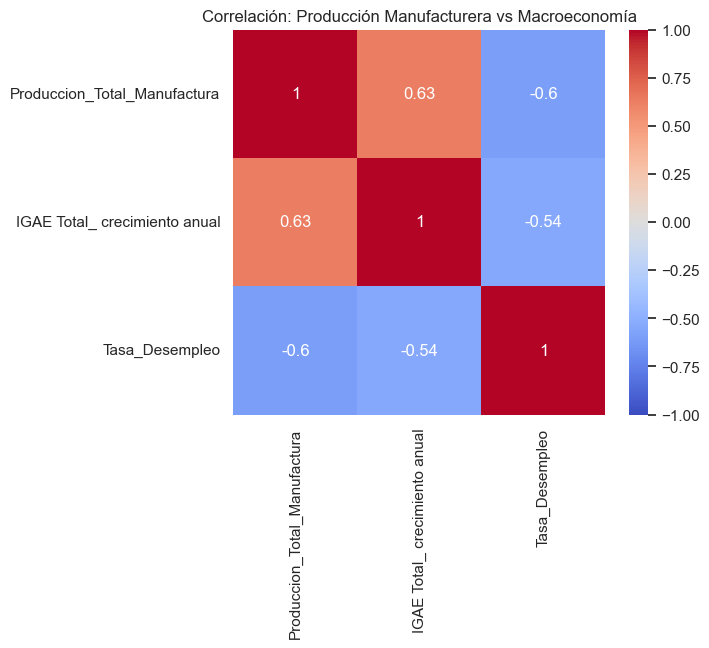

In [7]:
# 1. Procesar IGAE (Promedio anual)
df_igae['Fecha'] = pd.to_datetime(df_igae['Fecha'])
df_igae['ANIO'] = df_igae['Fecha'].dt.year
igae_anual = df_igae.groupby('ANIO')['IGAE Total_ crecimiento anual'].mean().reset_index()

# 2. Procesar Desempleo (Promedio anual)
# El formato es 'YYYY/MM', extraemos los primeros 4 caracteres
df_desempleo['ANIO'] = df_desempleo['Periodos'].astype(str).str[:4].astype(int)
col_desempleo = 'Serie desestacionalizada Porcentaje de la Población Económicamente Activa Mensual'
desempleo_anual = df_desempleo.groupby('ANIO')[col_desempleo].mean().reset_index()
desempleo_anual.rename(columns={col_desempleo: 'Tasa_Desempleo'}, inplace=True)

# 3. Procesar EAIM (Agregado anual de Producción)
eaim_anual = df_ip.groupby('ANIO')['PBT'].sum().reset_index()
eaim_anual.rename(columns={'PBT': 'Produccion_Total_Manufactura'}, inplace=True)

# 4. Unir todo
df_macro = pd.merge(eaim_anual, igae_anual, on='ANIO', how='inner')
df_macro = pd.merge(df_macro, desempleo_anual, on='ANIO', how='inner')

print("Datos Macro Integrados:")
print(df_macro)

# 5. Matriz de Correlación
corr_matrix = df_macro[['Produccion_Total_Manufactura', 'IGAE Total_ crecimiento anual', 'Tasa_Desempleo']].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación: Producción Manufacturera vs Macroeconomía')
plt.show()

## 8. Conclusiones

1. **Estructura Sectorial**: A través de los coeficientes técnicos, identificamos la dependencia de insumos vs valor agregado de cada sector.
2. **Tipología Industrial**: El análisis de clusters permitió segmentar la industria en grupos con características homogéneas (ej. alta productividad vs bajo valor agregado).
3. **Para la Relación Macro**: La correlación muestra cómo la producción manufacturera responde al crecimiento general (IGAE) y su relación inversa (o no) con el desempleo.